<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/InfoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It adds a “latent code” vector to traditional noise, and revises the loss function to include the cross-entropy between an estimated latent code by descriminator and the real one, it helps feature disentanglement




![alt text](https://i.imgur.com/kVd7gk1.png)

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
!mkdir images

Using TensorFlow backend.


In [0]:
class INFOGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.num_classes = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 72


        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', self.mutual_info_loss]

        # Build and the discriminator and recognition network
        self.discriminator, self.auxilliary = self.build_disk_and_q_net()

        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the recognition network Q
        self.auxilliary.compile(loss=[self.mutual_info_loss],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        gen_input = Input(shape=(self.latent_dim,))
        img = self.generator(gen_input)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        valid = self.discriminator(img)
        # The recognition network produces the label
        target_label = self.auxilliary(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(gen_input, [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

In [0]:
def build_generator(self):

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
    model.add(Activation("tanh"))

    gen_input = Input(shape=(self.latent_dim,))
    img = model(gen_input)

    model.summary()

    return Model(gen_input, img)

In [0]:
def build_disk_and_q_net(self):

    img = Input(shape=self.img_shape)

    # Shared layers between discriminator and recognition network
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())

    img_embedding = model(img)

    # Discriminator
    validity = Dense(1, activation='sigmoid')(img_embedding)

    # Recognition
    q_net = Dense(128, activation='relu')(img_embedding)
    label = Dense(self.num_classes, activation='softmax')(q_net)

    # Return discriminator and recognition network
    return Model(img, validity), Model(img, label)

In [0]:
def mutual_info_loss(self, c, c_given_x):
    """The mutual information metric we aim to minimize"""
    eps = 1e-8
    conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
    entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

    return conditional_entropy + entropy

def sample_generator_input(self, batch_size):
    # Generator inputs
    sampled_noise = np.random.normal(0, 1, (batch_size, 62))
    sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
    sampled_labels = to_categorical(sampled_labels, num_classes=self.num_classes)

    return sampled_noise, sampled_labels

In [0]:
def train(self, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and categorical labels
        sampled_noise, sampled_labels = self.sample_generator_input(batch_size)
        gen_input = np.concatenate((sampled_noise, sampled_labels), axis=1)

        # Generate a half batch of new images
        gen_imgs = self.generator.predict(gen_input)

        # Train on real and generated data
        d_loss_real = self.discriminator.train_on_batch(imgs, valid)
        d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

        # Avg. loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator and Q-network
        # ---------------------

        g_loss = self.combined.train_on_batch(gen_input, [valid, sampled_labels])

        # Plot the progress
        print ("%d [D loss: %.2f, acc.: %.2f%%] [Q loss: %.2f] [G loss: %.2f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[1], g_loss[2]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            self.sample_images(epoch)

In [0]:
def save_model(self):

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    save(self.generator, "generator")
    save(self.discriminator, "discriminator")


In [0]:

def sample_images(self, epoch):
    r, c = 10, 10

    fig, axs = plt.subplots(r, c)
    for i in range(c):
        sampled_noise, _ = self.sample_generator_input(c)
        label = to_categorical(np.full(fill_value=i, shape=(r,1)), num_classes=self.num_classes)
        gen_input = np.concatenate((sampled_noise, label), axis=1)
        gen_imgs = self.generator.predict(gen_input)
        gen_imgs = 0.5 * gen_imgs + 0.5
        for j in range(r):
            axs[j,i].imshow(gen_imgs[j,:,:,0], cmap='gray')
            axs[j,i].axis('off')
    fig.savefig("images/%d.png" % epoch)
    plt.close()


In [0]:
INFOGAN.build_generator = build_generator
INFOGAN.build_disk_and_q_net = build_disk_and_q_net
INFOGAN.mutual_info_loss = mutual_info_loss
INFOGAN.sample_generator_input = sample_generator_input
INFOGAN.save_model = save_model
INFOGAN.sample_images = sample_images
INFOGAN.train = train


In [0]:
infogan = INFOGAN()
infogan.train(epochs=50000, batch_size=128, sample_interval=50)

images/0.png	 images/200.png   images/3100.png  images/4200.png
images/1000.png  images/2050.png  images/3150.png  images/4250.png
images/100.png	 images/2100.png  images/3200.png  images/4300.png
images/1050.png  images/2150.png  images/3250.png  images/4350.png
images/1100.png  images/2200.png  images/3300.png  images/4400.png
images/1150.png  images/2250.png  images/3350.png  images/4450.png
images/1200.png  images/2300.png  images/3400.png  images/4500.png
images/1250.png  images/2350.png  images/3450.png  images/450.png
images/1300.png  images/2400.png  images/3500.png  images/4550.png
images/1350.png  images/2450.png  images/350.png   images/4600.png
images/1400.png  images/2500.png  images/3550.png  images/4650.png
images/1450.png  images/250.png   images/3600.png  images/4700.png
images/1500.png  images/2550.png  images/3650.png  images/4750.png
images/150.png	 images/2600.png  images/3700.png  images/500.png
images/1550.png  images/2650.png  images/3750.png  images/50.png
imag

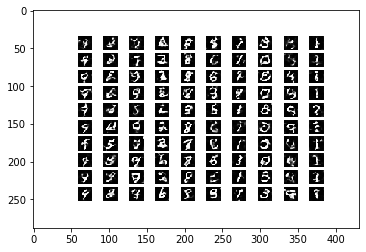

In [12]:
!ls images/*
img = plt.imread("images/4750.png")
plt.imshow(img)